# Almgren-Chriss Optimal Execution - Quadratic Programming

## Syllabus

1. Almgren-Chriss framework
2. Efficient frontier for implementation shortfall
3. Efficient frontier for VWAP
4. Efficient frontier for TWAP
5. Efficient Frontier: partial equilibrium

## 1. Almgren-Chriss framework

The **Almgren-Chriss framework** (1999) is a mathematical model that looks to:

- Estimate the optimal pace to build/unwind a trading position, issues often faced by brokers and traders (but has not seen as much interest from statisticians, economists and econophysicists in the past decades);
- Allows one to graphically represent the trade-off between slow/fast execution;
- Ease to choose one's own prefered approach to model market impact costs;
- Avoids the temptation of modelling the market as a physical system fully enclosed in its own data (*physics envy*);
- Designed from a bottom-top approach: the modelling is based on the execution process itself;
- Provides a multitude of modelling approaches to compute the slow/fast execution trade-off (e.g. KKT nonlinear optimization, dynamic programming, stochastic control, reinforcement learning, etc.).

We will present 2 approaches to solve the Almgren-Chriss model:

- Quadratic Programming (original method by Almgren-Chriss)
- Dynamic Programming

This notebook will focus on the **quadratic programming** approach.

**Assumptions**

- *Market impact*: we will follow the model assumptions made by Almgren, Thum, Hauptmann and Li (2005). Since we cannot estimate both permanent and temporary impact functions, we need to make assumptions on the structure of both functions. Almgren and al. (2005) through empirical evidence indicate that the temporary impact function should be concave, where $0<\beta<1$. The authors choose $\beta=0.5$. For the permanent impact, take $\alpha=1$ for practical simplification, to make the model free of arbitrage and have permanent impact independent of trading (cf. Guéant, 2016).

$$ h(n_k) = \varepsilon \, sign(n_k) + \eta |v|^{\beta}, \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, g(v) = \gamma v^{\alpha} $$

- *Trading trajectory*:

$$ x_0 = X,  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  n_k = x_k - x_{k-1},  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, x_k = X - \sum_{j=1}^k n_j = \sum_{j=k+1}^N n_k, \, \, \, \,\, \, \,\, \, \,   k=0,...,N $$

- *Price trajectory*: one of the reasons for choosing arithmetic Brownian motion (ABM) is that the optimal strategy will be dynamically optimal. If for example geometric Brownian motion (GBM) is assumed, the optimal strategy depends on the stock price.

$$ S_k = S_{k-1} + \sigma  \sqrt{\tau} \zeta_k - \tau g \left(\frac{n_k}{\tau}\right), \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, S_k = S_0 + \sigma  \sqrt{\tau} \sum_{j=1}^k \zeta_j - \gamma (X - x_k) $$

- *Temporary market impact on price:*

$$ \tilde S_k = S_{k-1} - h(\frac{n_k}{\tau}) $$

In [44]:
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [59]:
import os
path = os.getcwd()
df_total = pd.read_csv(path+"/data/FPEQUITY_10m.csv",delimiter =";",decimal =',')
df_total.head()
print(np.std(df_total[['Close']]))

Close    1.004009
dtype: float64


In [13]:


# Market impact functions

def g(x, gamma=2.5*10**(-7), alpha=1.0):
    """
    Permanent market impact
    """
    return gamma * x ** alpha

def h(x, eta=2.5*10**(-6), epsilon=0.0625, beta=1.0):
    """
    Temporary market impact
    """
    return epsilon*np.sign(x) + eta*(x/tau)**beta

Given a trading benchmark $B$, our goal is to minimize the following selling payoff:

$$Payoff=BenchmarkPayoff-RealizedPayoff$$

ie the problem writes:
$$\min \mathbb{E}\Big[e^{\theta(XB-\sum_{k=1}^nn_k\tilde{S_k})}\Big]$$

Noticing that the payoff is gaussian, the optimization problem can be rewritten as:

$$\min e^{\theta\mathbb{E}\big[XB-\sum_{k=1}^nn_k\tilde{S_k}\big]+\frac{\theta}{2}\mathbb{V}\big[XB-\sum_{k=1}^nn_k\tilde{S_k}\big]}$$
and equivalently:
$$\min \mathbb{E}\big[XB-\sum_{k=1}^nn_k\tilde{S_k}\big]+\lambda\mathbb{V}\big[XB-\sum_{k=1}^nn_k\tilde{S_k}\big]$$
with $\lambda = \frac{\theta}{2}$ the associated risk aversion.

## 2. Efficient frontier for implementation shortfall



### 2.1. Optimization

**Moments**

- *IS Algorithm*

$$ X_{IS} = X S_0 - \sum_{i=1}^N n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{IS}) = \sum_{i=1}^N \tau x_i g \left(\frac{n_i}{\tau}\right) + \sum_{i=1}^{N} n_i h \left(\frac{n_i}{\tau}\right) = \frac{1}{2} \gamma X^2 + \varepsilon \sum_{i=1}^N |n_i| + \frac{\eta-0.5\gamma \tau}{\tau} \sum_{i=1}^N n_i^2 $$

- *Variance*

$$ \mathbb{V}(X_{IS}) = \sigma^2 \sum_{i=1}^N \tau x_i^2 $$

Refresher:

$$ x_t = X - \sum_{j=1}^t n_j = \sum_{j=t+1}^N n_j $$

In [14]:
# Moments

def expectation_IS(N, tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    """
    Expectation of implementation shortfall.
    """
    exp = 0.5*gamma*X**2 + eps*np.sum(abs(N)) + (eta - 0.5*gamma*tau)/tau * np.sum(N**2)

    return exp

def variance_IS(N, sigma=0.3, tau=1.0):
    """
    Variance of implementation shortfall.
    """
    var = 0
    t = - 1
    while t < len(N) - 1:
        t = t + 1
        temp = (X - np.sum(N[0:t])) ** 2
        var = var + temp
    
    var = tau * (sigma**2) * var
    return var

# Objective function

def objective_IS(N):
    """
    Objective function for implementation shortfall.
    """
    obj = expectation_IS(N) + risk * variance_IS(N)
    return obj

We will use this function:

In [15]:
def efficient_frontier(X, risk, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    """
    Returns the optimal expectation and variance as well as the trading trajectory.
    It plots the trading trajectory.
    
    --------------------------------------------------------------------------
    Parameters:

    X, integer - Number of shares to be liquidated
    risk, float - Risk aversion coefficient
    nb_T, integer - Number of trading periods
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
        
    
    """
    V = np.sum(v)
    
    ########################################################################################################
    ############################################ MARKET IMPACT #############################################
    ########################################################################################################
    
    def g(x, gamma=2.5*10**(-7), alpha=1.0):
        """
        Permanent market impact
        """
        return gamma * x ** alpha

    def h(x, eta=2.5*10**(-6), epsilon=0.0625, beta=1.0):
        """
        Temporary market impact
        """
        return epsilon*np.sign(x) + eta*(x/tau)**beta

    ########################################################################################################
    ################################################## IS ##################################################
    ########################################################################################################
    
    def expectation_IS(n):
        """
        Returns the expectation of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        
        """
        
        exp = 0.5*gamma*X**2 + eps*np.sum(n) + (eta - 0.5*gamma)/tau * np.sum(n**2)
        return exp

    def variance_IS(n):
        """
        Returns the variance of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        sigma, array - Volatility of the stock
        
        """
        
        var = 0
        t = - 1
        while t < len(n) - 1:
            t = t + 1
            temp = (X - np.sum(n[0:t])) ** 2
            var = var + temp * sigma[t] **2
        var = tau * var
        return var
    
    def objective_IS(n):
        """
        Returns the objective function for implementation shortfall.
        """
        
        obj = expectation_IS(n) + risk * variance_IS(n)
        return obj
    
    ########################################################################################################
    ################################################## VWAP ################################################
    ########################################################################################################
    
    def expectation_VWAP(n):
        """
        Returns the expected VWAP.

        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        v, array - Volume traded during the day
        """
        # s0=100, tau=1, gamma=1, eta=1, eps=1

        N = len(n)
        e = 0
        V = v.sum()
        # T = tau * N
        for k in range(N):
            gsum = 0
            for j in range(k):
                gsum+=g(n[j]/tau)
            e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]/tau) + n[k]*h(n[k]/tau)
        return e

    def variance_VWAP(n):
        """
        Returns the VWAP variance
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        v, array - Volume traded during the day
        """
        # s0=100, X=1000, sigma=0.3, tau=1, gamma=1, eta=1, eps=1
        
        var = 0
        m = len(n)
        V = v.sum()
        for k in range(m):
            vsum = 0
            for j in range(k,m):
                vsum+=v[j]
            x = X - np.sum(n[0:k]) 
            var+=(X/V * vsum - x)**2 *sigma[k]**2
            # print(vsum*X/V, x)
        var = var*tau
        return var

    def objective_VWAP(n):
        """
        Objective function for VWAP.
        """
        obj = expectation_VWAP(n) + risk * variance_VWAP(n)
        return obj
    
    ########################################################################################################
    ################################################## TWAP ################################################
    ########################################################################################################
    
    def expectation_TWAP(n):
        """
        Returns the expected TWAP
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        """
        N = len(n)
        T = tau*N
        e = 0
        for k in range(N):
            sumg=0
            for j in range(k):
                sumg+=g(n[j]/tau)
            e+=(X*tau/T - n[k])*(s0-sumg*tau) - X/T * tau**2*g(n[k]/tau) + n[k]*h(n[k]/tau)
        return e

    def variance_TWAP(n):
        """
        Returns the TWAP variance
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        """
        var=0
        N = len(n)
        T = N * tau
        for k in range(N):
            tsum = 0
            for j in range(k,N):
                tsum+=tau
            x = X - np.sum(n[0:k])
            var+=(X/T * tsum-x)**2*sigma[k]**2*tau
        return var

    def objective_TWAP(n):
        return expectation_TWAP(n) + risk * variance_TWAP(n)
    
    ########################################################################################################
    ############################################ OPTIMIZATION ##############################################
    ########################################################################################################
    
    def optimization(benchmark):
        """
        Optimal execution with optimization for implementation shortfall.
        
        Returns the optimal trading trajectory.
        """
        
        x0  = np.ones((nb_T,1)) * X / nb_T
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        
        if benchmark == "IS":
            opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        elif benchmark == "VWAP":
            opt = sco.minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        elif benchmark == "TWAP":
            opt = sco.minimize(objective_TWAP, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        else:
            raise ValueError("Unknown benchmark: " + str(benchmark))
            
        n = np.array(opt.x)
        return n
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        
        """
        
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.title("Liquidation path for "+benchmark)
        plt.show()
        
    N_opt = optimization(benchmark)
    hist_opt = liquidation_history(N_opt,X)
    
    if plot=='True':
        plot_liquidation()
    
    if benchmark == 'IS':
        ex=expectation_IS(N_opt)
        va=variance_IS(N_opt)
    elif benchmark == 'VWAP':
        ex=expectation_VWAP(N_opt)
        va=variance_VWAP(N_opt)
    elif benchmark == 'TWAP':
        ex=expectation_TWAP(N_opt)
        va=variance_TWAP(N_opt)
    else:
        raise ValueError("Unknown benchmark.")
        
    res = hist_opt, ex,va
    
    return res

Risk aversion: 2e-07


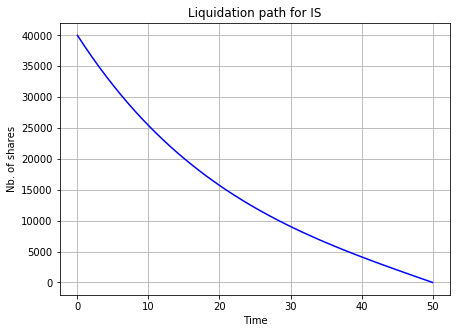

Risk aversion: -2e-07


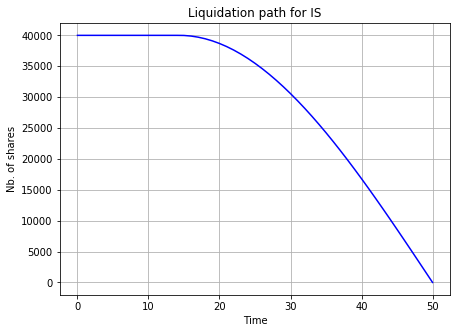

In [24]:
# Parameters definition
_tau = 0.5
_gamma = 2.5*10**(-7)
_eta = 2.5*10**(-6)
_eps = 0.0625

# Variables definition
_s0 = 100     # spot
_X = 40000    # Initial inventory
_nb_T = 50    # number of trading periods
_V = 4000000  # 
_cs = 0.3     # constant vol
_sigma = [_cs for t in range(_nb_T)]


# constant daily volume 
_v = np.ones((_nb_T,1)) * _V / _nb_T


print('Risk aversion:', 2*10**(-7))
test = efficient_frontier(X=_X, risk=2*10**(-7), nb_T=_nb_T, s0=_s0,v = _v,sigma=_sigma,
                          benchmark='IS',
                             tau=_tau,
                             gamma=_gamma,
                             eta=_eta,
                             eps=_eps)

print('Risk aversion:', -2*10**(-7))
test = efficient_frontier(X=_X, risk=-2*10**(-7), nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='IS',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

### 2.2. Efficient frontier

We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$

Now we plot the **efficient frontier** for implementation shortfall:

No handles with labels found to put in legend.


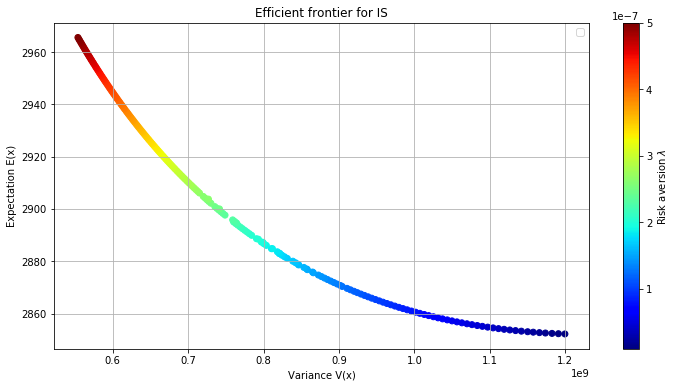

In [33]:
_nb_T = 50
_x0 = np.zeros((nb_T, 1))
_X = 40000
_risk = 0.05
_S0 = 100

def frontier_efficient(risks,X, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    
    """
    Plots the efficient frontier for a given benchmark
    """
    
    risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

    x = []
    y = []

    for r in risks:
        temp = efficient_frontier(X, r, nb_T, s0, v,sigma,benchmark, tau, gamma, eta, eps,False)
        x.append(temp[2])  # V(x)
        y.append(temp[1])  # E(x)

    # Plotting
    plt.figure(figsize=(12,6))

    # Optimal strategies
    plt.scatter(x, y, marker='o', cmap='jet', c=risks)
    #plt.plot(x_naive, y_naive, "ro", lw=2, markersize=10, label='Minimum impact', markeredgecolor='red')
    plt.grid(True)

    plt.xlabel('Variance V(x)')
    plt.ylabel('Expectation E(x)')
    plt.title('Efficient frontier for '+benchmark)
    plt.colorbar(label='Risk aversion $\lambda$')
    plt.legend(loc='best')
    plt.savefig('efficient_frontier_IS.png')
    plt.show()
    
risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)
frontier_efficient(risks,_X, _nb_T, _s0, _v,_sigma,benchmark='IS', tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6), eps=0.0625)

For **optimal liquidation trajectories**:

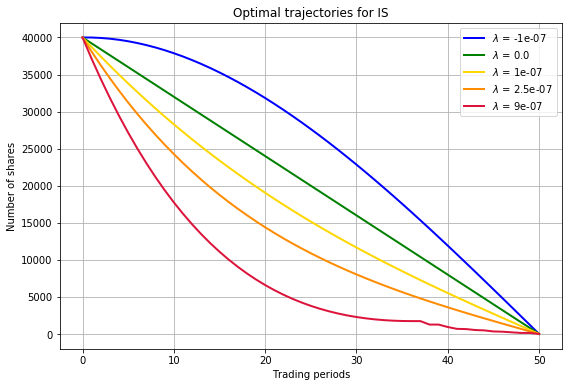

In [34]:
def comparison_ef(risks, X, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    
    """
    Polots the optimal trading trajectories for a list of risk aversion coefficients
    """
    
    N_opts = []

    for r in risks:
        temp = efficient_frontier(X, r, nb_T, s0, v,sigma,benchmark, tau, gamma, eta, eps,False)

        N_opts.append(temp[0])


    # Plotting
    plt.figure(figsize=(9,6))
    plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
    plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
    plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
    plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
    plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

    plt.grid(True)
    plt.title('Optimal trajectories for '+benchmark)
    plt.xlabel('Trading periods')
    plt.ylabel('Number of shares')
    plt.legend(loc='best')
    plt.savefig('liquidation_IS.png')
    plt.show()

risks = [-1*10**(-7), 0.0, 1.0*10**(-7), 2.5*10**(-7), 9.0*10**(-7)]
comparison_ef(risks,_X, _nb_T, _s0, _v,_sigma,benchmark='IS', tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6), eps=0.0625)

## 3. Efficient frontier for VWAP

### 3.1. Model

We adapt the Almgren-Chriss framework to the VWAP and TWAP algorithms with the help of O. Guéant's *The Financial Mathematics of Market Liquidity* (2016). VWAP (and TWAP) are popular algorithms among market making participants to follow closely the average price movements. The VWAP in particular is useful as a benchmark for both ensuring that the agent's liquidation decisions are in line with his strategy and low transaction costs.

**Moments**

- *VWAP Algorithm*

$$ X_{VWAP} = X\frac{\sum_{i=1}^n S_i V_i}{\sum_{i=1}^n V_i} - \sum_{i=1}^n n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{VWAP}) = \sum_{i=1}^n \left[\left(\frac{X}{V} V_i - n_i\right) \left (S_0 - \tau \sum_{j=1}^{i-1} g \left(\frac{n_j}{\tau}\right) \right) - \frac{X}{V} V_i \tau g \left(\frac{n_i}{\tau}\right) - n_i h\left(\frac{n_i}{\tau}\right)\right]$$

- *Variance*

$$ \mathbb{V}(X_{VWAP}) = \tau \sigma^2 \sum_{i=1}^n \left(\frac{X}{V} \sum_{j=i}^n V_j - x_i \right)^2 $$

**Optimization**

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_{VWAP}) + \lambda \mathbb{V}(X_{VWAP}) $$

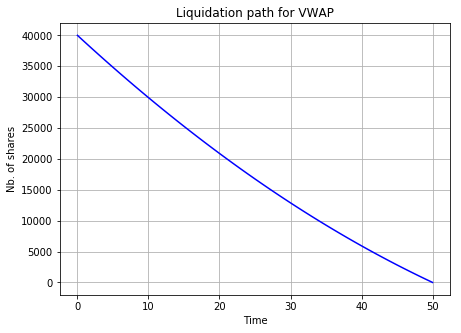

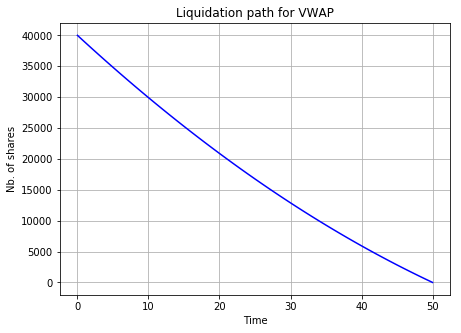

In [36]:
print('Risk aversion:', 5*10**(-7))
ef=efficient_frontier(X=_X, risk=-2*10**(-7), nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='VWAP',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)
print('Risk aversion:', -5*10**(-6))
ef=efficient_frontier(X=_X, risk=-2*10**(-7), nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='VWAP',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

### 3.2. Efficient frontier

We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$

for which we add for TWAP:

- $V=4000000$
- $V_i=80000, \,\,\, i=1,...,N$
- $S_0=100$

**Efficient frontier**:

In [ ]:
# Parameters definition
_tau = 0.5
_gamma = 2.5*10**(-7)
_eta = 2.5*10**(-6)
_eps = 0.0625

# Variables definition
_s0 = 100     # spot
_X = 40000    # Initial inventory
_nb_T = 50    # number of trading periods
_V = 4000000  # 
_cs = 0.3     # constant vol
_sigma = [_cs for t in range(_nb_T)]

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)
frontier_efficient(risks,X=_X, nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='VWAP',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

**Optimal liquidation trajectories**:

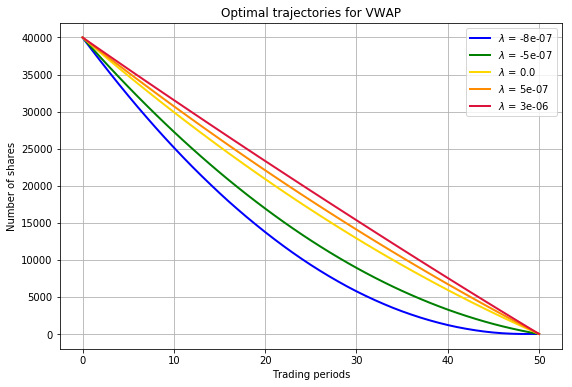

In [60]:
risks = [-8*10**(-7), -5*10**(-7), 0.0, 5*10**(-7), 30*10**(-7)]
comparison_ef(risks, _X, _nb_T, _s0, _v,_sigma,benchmark='VWAP', tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6), eps=0.0625)

Our previous implementation assumes that the traded volume is constant, which explains the *flatness* of the liquidation trajectory. A limitation that can be addressed by using data of past historical traded volumes.

## 4. Efficient frontier for TWAP

### 4.1. Model

**Moments**

- *TWAP Algorithm*

$$ X_{TWAP} = X\frac{\sum_{i=1}^n \tau S_i}{\sum_{i=1}^n \tau} - \sum_{i=1}^n n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{TWAP}) = \sum_{i=1}^n \left[\left(\frac{X}{T} \tau - n_i\right) \left (S_0 - \tau \sum_{j=1}^{i-1} g \left(\frac{n_j}{\tau}\right) \right) - \frac{X}{T} \tau^2 g \left(\frac{n_i}{\tau}\right) - n_i h\left(\frac{n_i}{\tau}\right)\right]$$

- *Variance*

$$ \mathbb{V}(X_{TWAP}) = \tau \sigma^2 \sum_{i=1}^n \left(\frac{X}{T} \sum_{j=i}^n \tau - x_i \right)^2 $$

**Optimization**

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_{TWAP}) + \lambda \mathbb{V}(X_{TWAP}) $$

Risk aversion: 5e-07


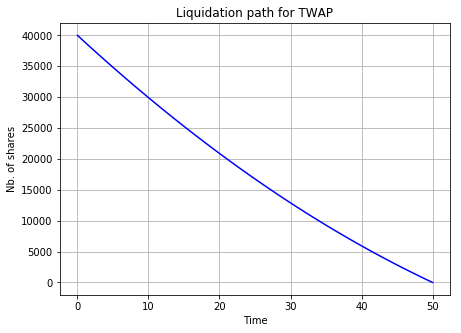

Risk aversion: -4.9999999999999996e-06


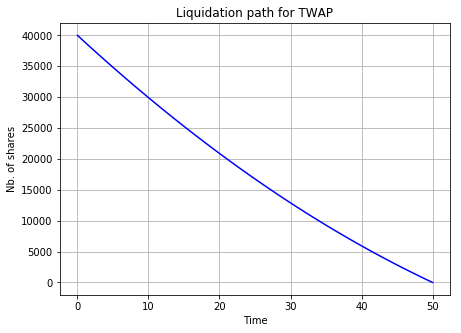

In [61]:
# Parameters
X = 40000.0                           # Number of shares to liquidate
nb_T = 10                             # Number of trading periods
risk = 2.5*10**(-7)                   # Risk aversion

tau = 0.5                             # Trading speed
gamma = 2.5*10**(-7)                  # Permanent market impact
eta = 2.5*10**(-6)                    # Temporary (variable) market impact
epsilon = 0.0625                          # Temporary (fixed) market impact
sigma = 0.3                           # Volatility
s0 = 100

print('Risk aversion:', 5*10**(-7))
ef=efficient_frontier(X=_X, risk=-2*10**(-7), nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='TWAP',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)
print('Risk aversion:', -5*10**(-6))
ef=efficient_frontier(X=_X, risk=-2*10**(-7), nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='TWAP',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

### 4.2. Efficient frontier


We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$
- $S_0=100$

**Efficient frontier**:

In [ ]:
# Parameters definition
_tau = 0.5
_gamma = 2.5*10**(-7)
_eta = 2.5*10**(-6)
_eps = 0.0625

# Variables definition
_s0 = 100     # spot
_X = 40000    # Initial inventory
_nb_T = 50    # number of trading periods
_V = 4000000  # 
_cs = 0.3     # constant vol
_sigma = [_cs for t in range(_nb_T)]

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)
frontier_efficient(risks,X=_X, nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='TWAP',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

**Optimal liquidation trajectories**:

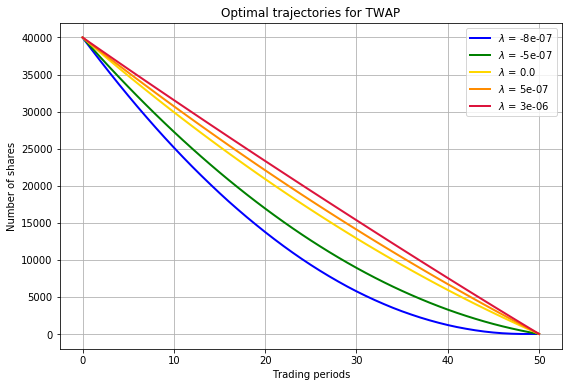

In [63]:
risks = [-8*10**(-7), -5*10**(-7), 0.0, 5*10**(-7), 30*10**(-7)]
comparison_ef(risks, X=_X, nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='TWAP',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

## 5. Efficient frontier: partial equilibrium

### 5.1. Market impact functions

In [153]:
def efficient_frontier_VWAP_MI(X, risk, nb_T, v, alpha, beta, sigma=0.3, s0=100, tau=0.5,
                               gamma=2.5*10**(-7), eta=2.5*10**(-6), epsilon=0.0625, plot='True'):
    
    def g(x):
        return gamma * x ** alpha

    def h(x):
        return epsilon * np.sign(x) + eta * (x/tau) ** beta
    
    def expectation_VWAP(n):
        N = len(n)
        e = 0
        V = v.sum()
        # T = tau * N
        for k in range(N):
            gsum = 0
            for j in range(k):
                gsum+=g(n[j]/tau)
            e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]) + n[k]*h(n[k]/tau)
        return e
    
    def variance_VWAP(n):
        var = 0
        N = len(n)
        V = v.sum()
        for k in range(N):
            vsum = 0
            for j in range(k,N):
                vsum+=v[j]
            x = X - np.sum(n[0:k])
            var+=(X/V * vsum - x)**2
        var = var*sigma**2*tau
        return var

    def objective_VWAP(n):
        obj = expectation_VWAP(n) + risk * variance_VWAP(n)
        return obj
    
    def optimization_VWAP():
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds,
                       constraints=cons, options={'maxiter': 10000})
        N = np.array(opt.x)
        return N
    
    N_opt = optimization_VWAP()
    
    def liquidation_history(N_opt, X):
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt, expectation_VWAP(N_opt), variance_VWAP(N_opt)
    
    return res

We have:

$$ h(n_k) = \varepsilon \, sign(n_k) + \eta |v|^{\beta}, \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, g(v) = \gamma v^{\alpha} $$

Thus:

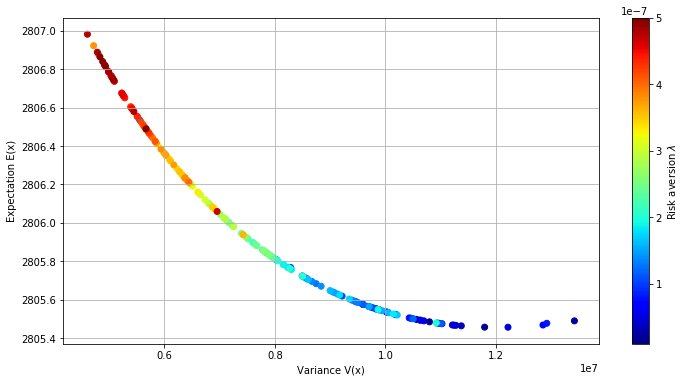

In [159]:
alpha = 1.0
beta = 1.0

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi1 = []
y_VWAP_mi1 = []

for r in risks:
    temp = efficient_frontier(X=_X, risk=-2*10**(-7), nb_T=_nb_T,s0=100,v = _v,sigma=_sigma,
                          benchmark='TWAP',
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625,
                             plot=False)
    
    x_VWAP_mi1.append(temp[2])  # V(x)
    y_VWAP_mi1.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi1), np.ravel(y_VWAP_mi1), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A1.png')
plt.show()

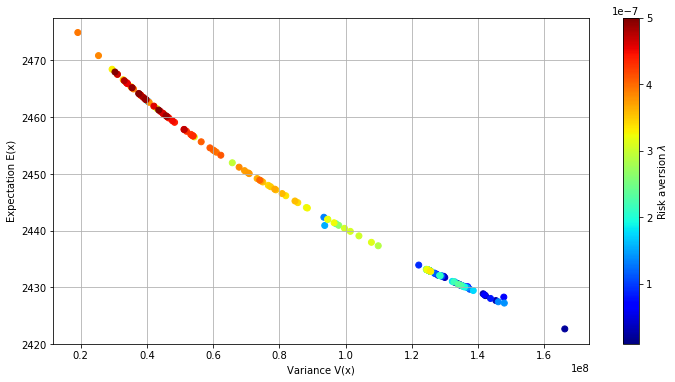

In [160]:
alpha = 1.0
beta = 0.5

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi2 = []
y_VWAP_mi2 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi2.append(temp[2])  # V(x)
    y_VWAP_mi2.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi2), np.ravel(y_VWAP_mi2), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A2.png')
plt.show()

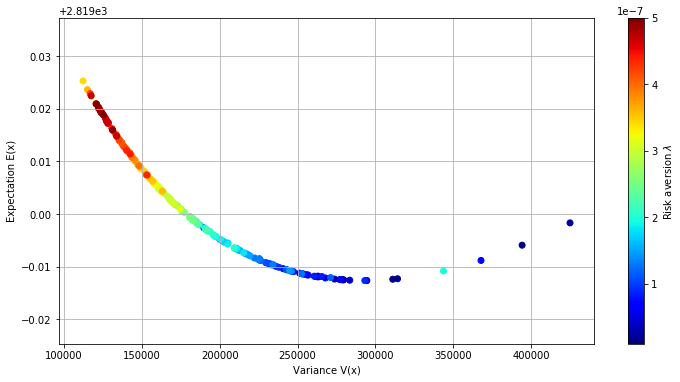

In [162]:
alpha = 0.75
beta = 1.0

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi3 = []
y_VWAP_mi3 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi3.append(temp[2])  # V(x)
    y_VWAP_mi3.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi3), np.ravel(y_VWAP_mi3), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A3.png')
plt.show()

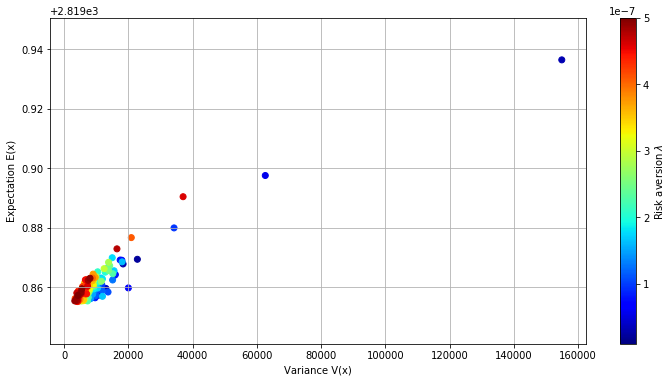

In [168]:
alpha = 0.5
beta = 1.0

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi4 = []
y_VWAP_mi4 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi4.append(temp[2])  # V(x)
    y_VWAP_mi4.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi4), np.ravel(y_VWAP_mi4), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A4.png')
plt.show()

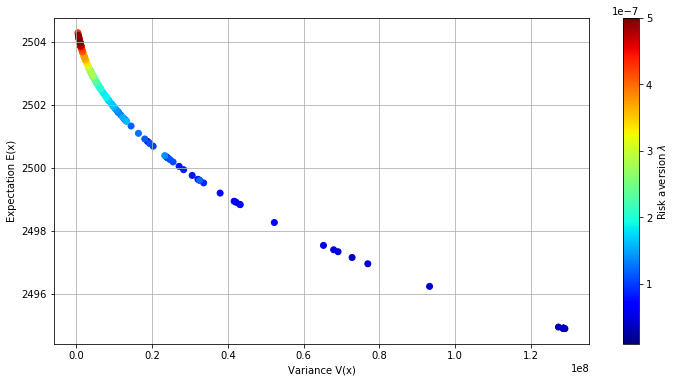

In [170]:
alpha = 0.75
beta = 0.5

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi5 = []
y_VWAP_mi5 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi5.append(temp[2])  # V(x)
    y_VWAP_mi5.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi5), np.ravel(y_VWAP_mi5), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A5.png')
plt.show()

Comparaison for different $(\alpha,\beta)$ values:

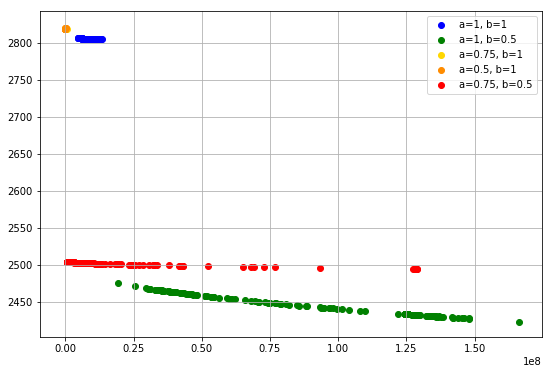

In [197]:
plt.figure(figsize=(9,6))
plt.scatter(np.ravel(x_VWAP_mi1), np.ravel(y_VWAP_mi1), marker='o', color='blue', label='a=1, b=1')
plt.scatter(np.ravel(x_VWAP_mi2), np.ravel(y_VWAP_mi2), marker='o', color='green', label='a=1, b=0.5')
plt.scatter(np.ravel(x_VWAP_mi3), np.ravel(y_VWAP_mi3), marker='o', color='gold', label='a=0.75, b=1')
plt.scatter(np.ravel(x_VWAP_mi4), np.ravel(y_VWAP_mi4), marker='o', color='darkorange', label='a=0.5, b=1')
plt.scatter(np.ravel(x_VWAP_mi5), np.ravel(y_VWAP_mi5), marker='o', color='red', label='a=0.75, b=0.5')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('tests_Asum.png')
plt.show()

### 5.2. Volatility $\sigma$

In [200]:
sigmas = np.linspace(0.05, 0.75, 20)
sigmas

array([ 0.05      ,  0.08684211,  0.12368421,  0.16052632,  0.19736842,
        0.23421053,  0.27105263,  0.30789474,  0.34473684,  0.38157895,
        0.41842105,  0.45526316,  0.49210526,  0.52894737,  0.56578947,
        0.60263158,  0.63947368,  0.67631579,  0.71315789,  0.75      ])

## References

- Robert Almgren, Chee Thum, Emmanuel Hauptmann and Hong Li, *Direct Estimation of Equity Market Impact*, 2005
- Robert Almgren and Neil Chriss, *Optimal Execution of Portfolio Transactions*, 2000
- Lan Zhang, Per A. Mykland, Yacine Aït-Sahalia,  *A Tale of Two Time Scales: Determining Integrated Volatility With Noisy High-Frequency Data*, 2005
- Olivier Guéant, *The Mathematics of Financial Liquidity: From Optimal Execution to Market Making*, 2015